# Convolutional neural network model

In [1]:
# Standard library imports
import os.path
import glob
import pickle
import random

# PyPI imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image

2025-01-14 16:33:18.799320: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Data preparation
### 1.1. Load data paths

In [2]:
# Set the path to the training data
training_data_path='../data'

# Get a list of training dog and cat images
idc_pos=glob.glob(f'{training_data_path}/idc_positive/*.png')
idc_neg=glob.glob(f'{training_data_path}/idc_negative/*.png')

### 1.2. Inspect

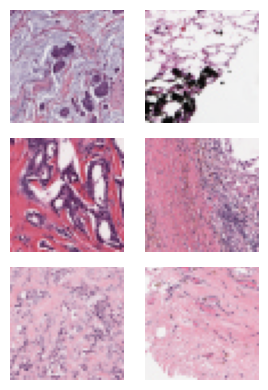

In [3]:
# Plot some of the cat and dog images
fig, axs = plt.subplots(3,2,figsize=(3, 4))

for idc_pos_path, idc_neg_path, row in zip(idc_pos, idc_neg, axs):
    for patch, ax in zip([idc_pos_path, idc_neg_path], row):
        patch=image.load_img(patch)
        patch=image.img_to_array(patch)
        patch/=255.0
        ax.imshow(patch)
        ax.axis('off')

plt.tight_layout()
plt.show()

## 2. EDA

Not much to do here - we could try and look for 'bad' images, but it's hard to define what that is. We can do two things:

1. Make sure all of the images actually load - this will catch any that are broken or mangled at the file level
2. Check the dimensions - this will make sure that they are actually all 50x50 pixels

## 2.1. Test loading

In [4]:
%%time

# Test load all of the images. Not going to do anything with them, just checking to see if we get any errors
errors=0

for i, image_path in enumerate(idc_pos+idc_neg):

    try:
        # Load the image and convert it to an array
        sample_image=image.load_img(image_path)
        sample_image=image.img_to_array(sample_image)

    except:
        errors+=1

print(f'Loaded {i} images with {errors} errors\n')

Loaded 277523 images with 0 errors

CPU times: user 52.5 s, sys: 13.7 s, total: 1min 6s
Wall time: 1min 18s


### 2.2. Image dimensions

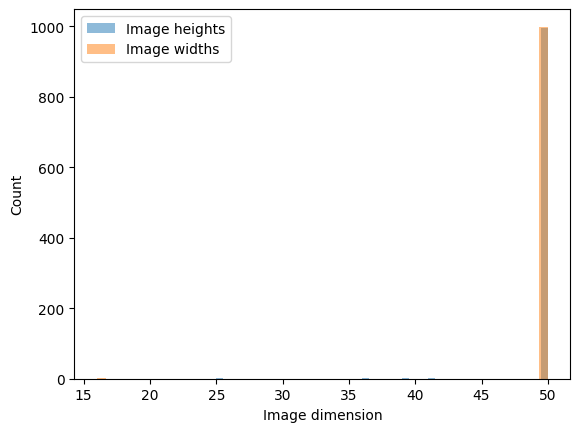

In [5]:
# Get a random sample of images
sample_size=1000
sample=random.sample(idc_pos, sample_size//2)
sample+=random.sample(idc_neg, sample_size//2)

# Collectors for data
heights=[]
widths=[]

# Loop on the sample images
for sample_image in sample:

    # Load the image and convert it to an array
    sample_image=image.load_img(sample_image)
    sample_image=image.img_to_array(sample_image)

    # Get the width and height and add to collections
    heights.append(sample_image.shape[0])
    widths.append(sample_image.shape[1])

# Plot results as a histogram
plt.hist(heights, bins=50, alpha=0.5, label='Image heights')
plt.hist(widths, bins=50, alpha=0.5, label='Image widths')
plt.xlabel('Image dimension')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

## 3. Model

### 3.1. Data generator function

In [6]:
# Define a re-usable helper function to create training and validation datasets
def make_datasets(training_data_path, image_width, image_height, batch_size: int=32):
    '''Makes training and validation dataset generator objects.'''

    training_dataset=tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='training',
        seed=315,
        image_size=(image_width, image_height),
        color_mode='grayscale',
        batch_size=batch_size
    )

    validation_dataset=tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='validation',
        seed=315,
        image_size=(image_width, image_height),
        color_mode='grayscale',
        batch_size=batch_size
    )

    return training_dataset, validation_dataset

### 3.2. Model building function

In [7]:
# Define a re-usable helper function to define and compile the model
def compile_model(training_dataset, image_width, image_height, learning_rate, l1, l2):
    '''Builds the convolutional neural network classification model'''

    # Define and adapt a normalization layer. This step uses a sample of images 
    # from the training dataset to calculate the mean and standard deviation 
    # which will then be used to normalize the data during training
    sample_data=training_dataset.take(1000)
    adapt_data=sample_data.map(lambda x, y: x)
    norm_layer=tf.keras.layers.Normalization()
    norm_layer.adapt(adapt_data)

    # Set the weight initializer function
    initializer=tf.keras.initializers.GlorotUniform(seed=315)

    # Set-up the L1L2 for the dense layers
    regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2)

    # Define the model layers in order
    model=Sequential([
        layers.Input((image_width, image_height, 1)),
        norm_layer,
        layers.Conv2D(16, 3, activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, 3, activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, 3, activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
        layers.Dense(64, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
        layers.Dense(1, activation='sigmoid', kernel_initializer=initializer)
    ])

    # Define the optimizer
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model, specifying the type of loss to use during training and any extra
    # metrics to evaluate
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])

    return model

### 3.3. Training function

In [8]:
# Define a re-usable helper function that does a single training run with
# optional arguments for common hyperparameters
def single_training_run(
        training_data_path: str,
        image_width: int=50,
        aspect_ratio: float=1.0,
        batch_size: int=16,
        learning_rate: float=0.1,
        l1_penalty: float=0.0,
        l2_penalty: float=0.0,
        epochs: int=100,
        steps_per_epoch: int=50,
        validation_steps: int=50
):
    '''Does one training run.'''

    # Get dictionary of all arguments being passed into function
    named_args = {**locals()}

    # Make output file name string using values of arguments
    # from function call
    results_file='../data/experiment_results/single_model_run'
    for key, value in named_args.items():
        if key != 'training_data_path':
            results_file+=f'_{value}'
    results_file+='.plk'

    # Check if we have already run this experiment, if not, run it and save the results
    if os.path.isfile(results_file) == False:

        # Calculate the image height from the width and target aspect ratio
        image_height=int(image_width / aspect_ratio)

        # Make the streaming datasets
        training_dataset, validation_dataset=make_datasets(
            training_data_path,
            image_width,
            image_height,
            batch_size
        )

        # Make the model
        model=compile_model(
            training_dataset,
            image_width,
            image_height,
            learning_rate,
            l1_penalty,
            l2_penalty
        )

        # Do the training run
        training_result=model.fit(
            training_dataset.repeat(),
            validation_data=validation_dataset.repeat(),
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            verbose=False
        )

        # Save the results
        with open(results_file, 'wb') as output_file:
            pickle.dump(training_result, output_file, protocol=pickle.HIGHEST_PROTOCOL)

    # If we have already run it, load the result so we can plot it
    elif os.path.isfile(results_file) == True:
        with open(results_file, 'rb') as output_file:
            training_result=pickle.load(output_file)

    return training_result

### 3.4. Baseline training run

In [9]:
# Do a single training run with default settings
training_results=single_training_run(training_data_path)

# Collect the results so we can plot all of the experiments together at the end
experiment_results={'Baseline model': training_results}

Found 277524 files belonging to 3 classes.
Using 222020 files for training.
Found 277524 files belonging to 3 classes.
Using 55504 files for validation.


2025-01-14 16:35:18.234330: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-14 16:35:20.166494: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24532992 exceeds 10% of free system memory.
2025-01-14 16:35:20.166600: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24532992 exceeds 10% of free system memory.
2025-01-14 16:35:20.201174: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24532992 exceeds 10% of free system memory.
2025-01-14 16:35:20.204736: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24532992 exceeds 10% of free system memory.
2025-01-14 16:35:20.237329: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24532992 exceeds 10% of free system memory.


### 3.5. Plot baseline results

In [12]:
# Define a re-useable helper function that plots the results of a single training run
def plot_single_training_run(training_results):
    '''Takes a training results dictionary, plots it.'''

    # Set-up a 1x2 figure for accuracy and binary cross-entropy
    fig, axs=plt.subplots(1,2, figsize=(8,4))

    # Add the main title
    fig.suptitle('CNN training curves', size='large')

    # Plot training and validation accuracy
    axs[0].set_title('Accuracy')
    axs[0].plot(np.array(training_results.history['binary_accuracy']) * 100, label='Training')
    axs[0].plot(np.array(training_results.history['val_binary_accuracy']) * 100, label='Validation')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy (%)')
    axs[0].legend(loc='upper left')

    # Plot training and validation binary cross-entropy
    axs[1].set_title('Binary cross-entropy')
    axs[1].plot(training_results.history['loss'])
    axs[1].plot(training_results.history['val_loss'])
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Binary cross-entropy')

    # Show the plot
    plt.tight_layout()

    return plt

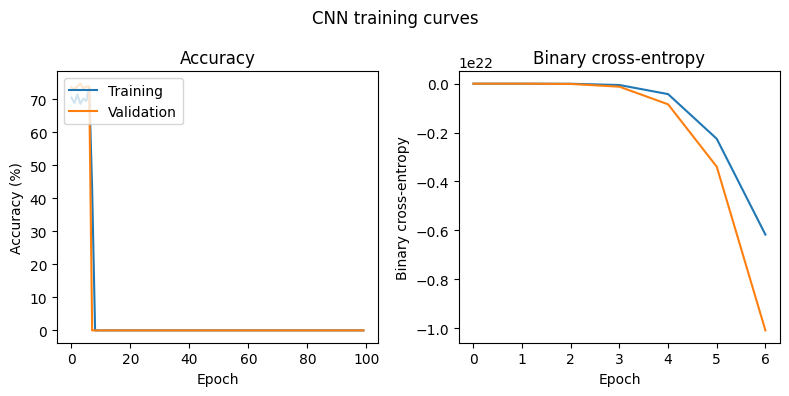

In [13]:
# Plot the results
plot_single_training_run(training_results).show()